### Direct Continuation from PDF Graph Generation on Perplexity AI 

#### USER INPUT: 
can you adapt the code to create a simulated trade off between the probability that a patient is delayed (p(delay)) and the number of bed available in the acute unit. the p delay should be calcualted using PDF and CDF and use the erlang formula p(delay)=P(N≤n)P(N=n)

#### AI OUTPUT:
Here's a comprehensive solution incorporating the Erlang C formula to analyze the trade-off between bed capacity and delay probability in the Acute Stroke Unit (ASU):

Total traffic intensity: 10.72 Erlangs
Beds: 10 | Simulated P(delay): 0.011 | Theoretical P(delay): 1.000
Beds: 11 | Simulated P(delay): 0.000 | Theoretical P(delay): 0.000
Beds: 12 | Simulated P(delay): 0.002 | Theoretical P(delay): 0.000
Beds: 13 | Simulated P(delay): 0.000 | Theoretical P(delay): 0.000
Beds: 14 | Simulated P(delay): 0.000 | Theoretical P(delay): 0.000
Beds: 15 | Simulated P(delay): 0.000 | Theoretical P(delay): 0.000
Beds: 16 | Simulated P(delay): 0.000 | Theoretical P(delay): 0.000
Beds: 17 | Simulated P(delay): 0.000 | Theoretical P(delay): 0.000
Beds: 18 | Simulated P(delay): 0.000 | Theoretical P(delay): 0.000
Beds: 19 | Simulated P(delay): 0.000 | Theoretical P(delay): 0.000
Beds: 20 | Simulated P(delay): 0.000 | Theoretical P(delay): 0.000
Beds: 21 | Simulated P(delay): 0.000 | Theoretical P(delay): 0.000
Beds: 22 | Simulated P(delay): 0.000 | Theoretical P(delay): 0.000
Beds: 23 | Simulated P(delay): 0.000 | Theoretical P(delay): 0.000
Beds: 24 | Simulated P(

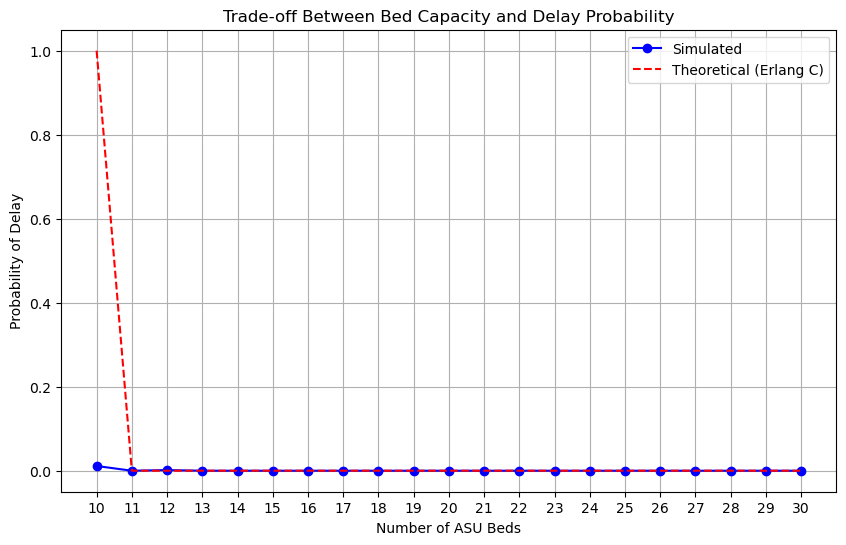

In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
from math import factorial, exp

# Configuration
PATIENT_TYPES = {
    "Stroke": 1.2,
    "TIA": 9.3,
    "Complex Neurological": 3.6,
    "Other": 3.2
}
ASU_LENGTH_OF_STAY = 7
REHAB_LENGTH_OF_STAY = 25
DESTINATIONS = {"Rehab Unit": 0.4, "ESD": 0.3, "Other": 0.3}
SIMULATION_DAYS = 365 * 5  # 5 years
BED_RANGE = range(10, 31)  # Test bed capacities from 10 to 30

def erlang_c(A, c):
    """Calculates Erlang C probability using recursive approximation"""
    if A >= c:
        return 1.0  # System is unstable, 100% delay probability
    
    # Calculate summation term
    sum_term = sum((A**k)/factorial(k) for k in range(c))
    
    # Calculate Erlang C numerator and denominator
    numerator = (A**c) / factorial(c)
    denominator = (sum_term * factorial(c)) + (A**c) * (c/(c - A))
    
    return numerator / denominator

def calculate_traffic_intensity():
    """Calculates total traffic intensity in Erlangs"""
    total_arrival_rate = sum(1/rate for rate in PATIENT_TYPES.values())
    return total_arrival_rate * ASU_LENGTH_OF_STAY

def simulate_asu(n_beds):
    """Runs a single simulation with specified bed count"""
    env = simpy.Environment()
    asu = simpy.Resource(env, capacity=n_beds)
    rehab = simpy.Resource(env, capacity=float('inf'))
    
    stats = {'delayed': 0, 'total': 0}
    
    def patient_generator():
        while True:
            patient_type = random.choices(
                list(PATIENT_TYPES.keys()),
                weights=[1/rate for rate in PATIENT_TYPES.values()]
            )[0]
            
            env.process(patient_stay({
                "type": patient_type,
                "admission_time": env.now
            }))
            
            interarrival = random.expovariate(1/PATIENT_TYPES[patient_type])
            yield env.timeout(interarrival)
    
    def patient_stay(patient):
        nonlocal stats
        arrival_time = env.now
        req = asu.request()
        yield req
        stats['total'] += 1
        if env.now > arrival_time:
            stats['delayed'] += 1
        
        # ASU stay
        yield env.timeout(ASU_LENGTH_OF_STAY)
        asu.release(req)
        
        # Destination handling
        destination = random.choices(
            list(DESTINATIONS.keys()),
            weights=list(DESTINATIONS.values())
        )[0]
        
        if destination == "Rehab Unit":
            with rehab.request() as rehab_req:
                yield rehab_req
                yield env.timeout(REHAB_LENGTH_OF_STAY)
    
    env.process(patient_generator())
    env.run(until=SIMULATION_DAYS)
    return stats['delayed']/stats['total'] if stats['total'] > 0 else 0

# Calculate traffic intensity
A = calculate_traffic_intensity()
print(f"Total traffic intensity: {A:.2f} Erlangs")

# Run simulations and calculations
sim_results = []
theory_results = []

for beds in BED_RANGE:
    # Simulated probability
    p_delay_sim = simulate_asu(beds)
    sim_results.append(p_delay_sim)
    
    # Theoretical probability (Erlang C)
    p_delay_theory = erlang_c(A, beds)
    theory_results.append(p_delay_theory)
    
    print(f"Beds: {beds:2d} | Simulated P(delay): {p_delay_sim:.3f} | Theoretical P(delay): {p_delay_theory:.3f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(BED_RANGE, sim_results, 'bo-', label='Simulated')
plt.plot(BED_RANGE, theory_results, 'r--', label='Theoretical (Erlang C)')
plt.xlabel('Number of ASU Beds')
plt.ylabel('Probability of Delay')
plt.title('Trade-off Between Bed Capacity and Delay Probability')
plt.legend()
plt.grid(True)
plt.xticks(BED_RANGE)
plt.show()